# 🔵 **Import Libraries**

In [19]:
import nltk
from nltk.tokenize import word_tokenize
import torch
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import lognorm, pareto
import time

In [20]:
print('torch: ', torch.__version__)
print('nltk: ', nltk.__version__)
print('datasets: ', datasets.__version__)
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('seaborn: ', sns.__version__)
print('scipy: ', scipy.__version__)

torch:  2.2.0+cu121
nltk:  3.9.1
datasets:  3.6.0
numpy:  1.26.4
pandas:  2.2.2
seaborn:  0.13.2
scipy:  1.13.1


# 🔵 **TinyStories Dataset**

## 🔵 **LoadDataset**

In [23]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [24]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']
print('Number of train rows(stories): ', train_dataset.num_rows/1e6, 'Million rows(stories)')
print('Number of valid rows(stories): ', valid_dataset.num_rows/1e6, 'Million rows(stories)')

Number of train rows(stories):  2.119719 Million rows(stories)
Number of valid rows(stories):  0.02199 Million rows(stories)


In [25]:
[print(f'story{i+1}: \n\n', train_dataset[i]['text'], '\n') for i in range(5)]

story1: 

 One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together. 

story2: 

 Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many lea

[None, None, None, None, None]

## 🔵 **EDA(Exploratory Data Analysis)**

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
tokenizer = word_tokenize

In [36]:
try:
    args = torch.load('args.pt')
    num_tok, num_char, char_counts, token_counts = args['num_tok'], args['num_char'], args['char_counts'], args['token_counts']
    dataset_size = len(train_dataset['text'])
except:
    num_tok  = 0
    num_char = 0
    char_counts  = Counter()
    token_counts = Counter()
    batch = 512
    dataset_size = len(train_dataset['text'])
    
    with tqdm(range(dataset_size // batch + 1), desc="📊 Processing batches") as tep:
        for i in tep:
            batch_texts = train_dataset[i * batch : (i + 1) * batch]['text']
            text = " ".join(batch_texts)
            num_char += len(text)
            char_counts.update(text)
            tokenized = tokenizer(text)
            num_tok += len(tokenized)
            token_counts.update(tokenized)
            tep.set_postfix(
                unique_tokens=len(token_counts),
                total_tokens=num_tok,
                total_chars=num_char,
                unique_chars=len(char_counts),
                most_common_char=char_counts.most_common(1)[0][0])
    args = dict(num_tok = num_tok, num_char = num_char, char_counts = char_counts, token_counts = token_counts)
    torch.save(args, 'args.pt')

### 🔵 **Character Level**

In [38]:
num_char

1902088781

In [40]:
df_count_ch = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count'])

In [42]:
df_count_ch.describe()

,count
count,1.740000e+02
mean,1.093154e+07
std,3.733032e+07
min,1.000000e+00
25%,1.025000e+01
50%,3.745000e+02
75%,1.213577e+06
max,3.642332e+08


In [44]:
df_count_ch[df_count_ch['count']==1]

,count
|,1
Ñ,1
ƒ,1
µ,1
®,1
î,1
Ò,1


In [46]:
df_count_ch[df_count_ch['count']>1.093154e+07].shape, df_count_ch[df_count_ch['count']<1.093154e+07].shape

((27, 1), (147, 1))

In [48]:
df_count_ch.sort_values('count', ascending=False).head(10)

,count
,364233176
e,180782399
a,127963378
t,118625067
o,99438049
h,93158669
n,88723326
i,81541616
d,81365133
s,78717020


In [50]:
df_count_ch.sort_values('count', ascending=False).tail(10)

,count
²,2
@,2
É,2
Ñ,1
ƒ,1
µ,1
®,1
î,1
|,1
Ò,1


In [52]:
364233176/num_char # Space character

0.19149115416605783

In [54]:
df_count_ch[df_count_ch['count'] == 1].shape, df_count_ch[df_count_ch['count'] == 2].shape, df_count_ch[df_count_ch['count'] == 3].shape

((7, 1), (4, 1), (2, 1))

In [56]:
df_count_ch[df_count_ch['count'] > 3].shape

(161, 1)

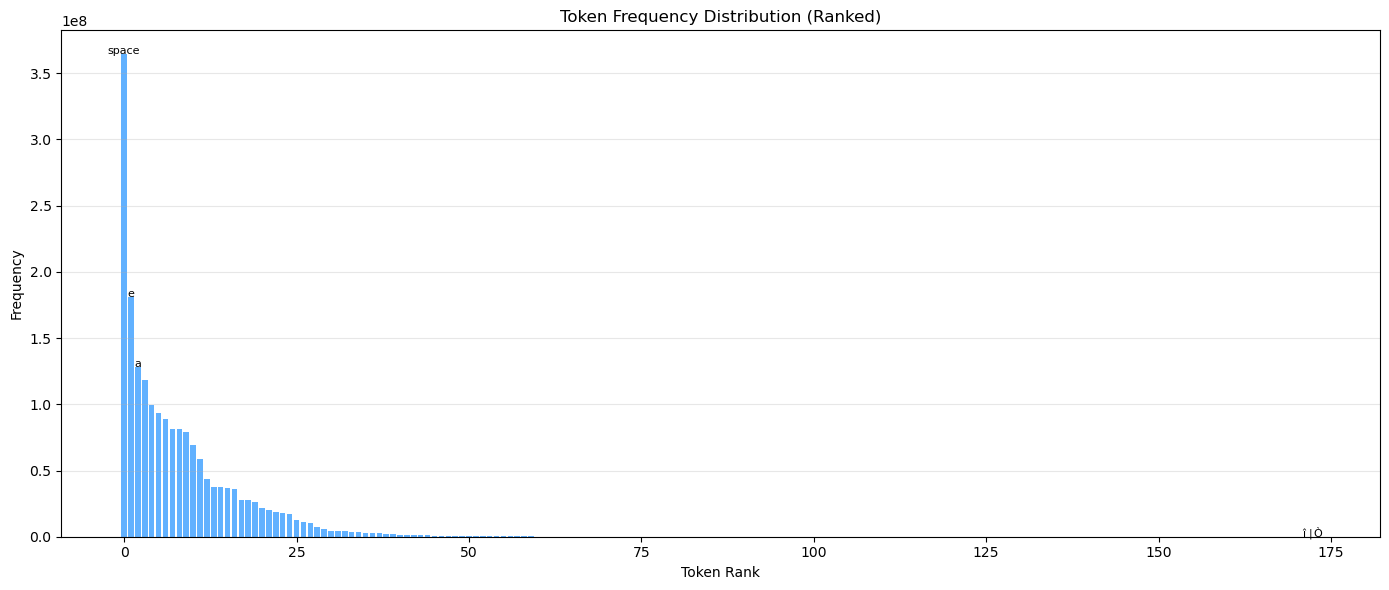

In [58]:
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df_count_ch.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(len(df_sorted)), df_sorted['count'],
        color='dodgerblue', alpha=0.7, width=0.8)

plt.title('Token Frequency Distribution (Ranked)')
plt.xlabel('Token Rank')
plt.ylabel('Frequency')
for rank in [0, 1, 2, -3, -2, -1]:
    token = df_sorted.index[rank]
    plt.text(range(df_sorted.shape[0])[rank], df_sorted['count'].iloc[rank], token  if rank!=0 else "space", ha='center', fontsize=8)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
df_sorted.iloc[:50].sum()/num_char

count    0.998122
dtype: float64

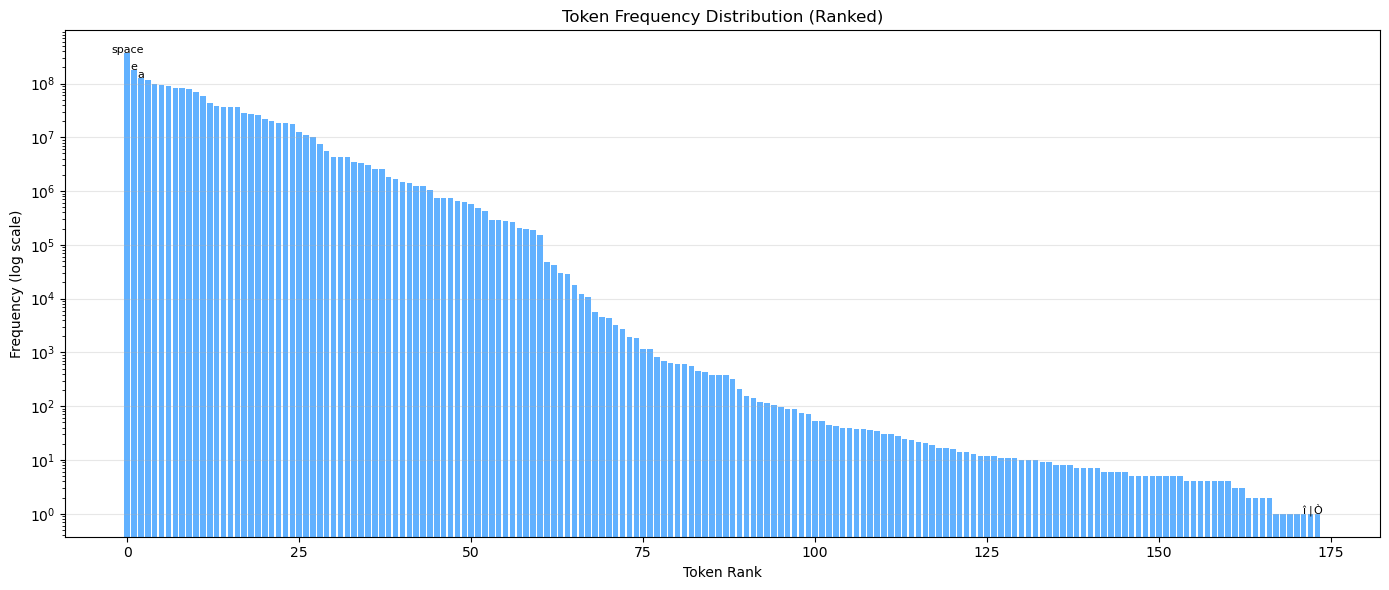

In [62]:
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df_count_ch.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(len(df_sorted)), df_sorted['count'],
        color='dodgerblue', alpha=0.7, width=0.8)

plt.yscale('log')
plt.title('Token Frequency Distribution (Ranked)')
plt.xlabel('Token Rank')
plt.ylabel('Frequency (log scale)')
for rank in [0, 1, 2, -3, -2, -1]:
    token = df_sorted.index[rank]
    plt.text(range(df_sorted.shape[0])[rank], df_sorted['count'].iloc[rank], token  if rank!=0 else "space", ha='center', fontsize=8)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

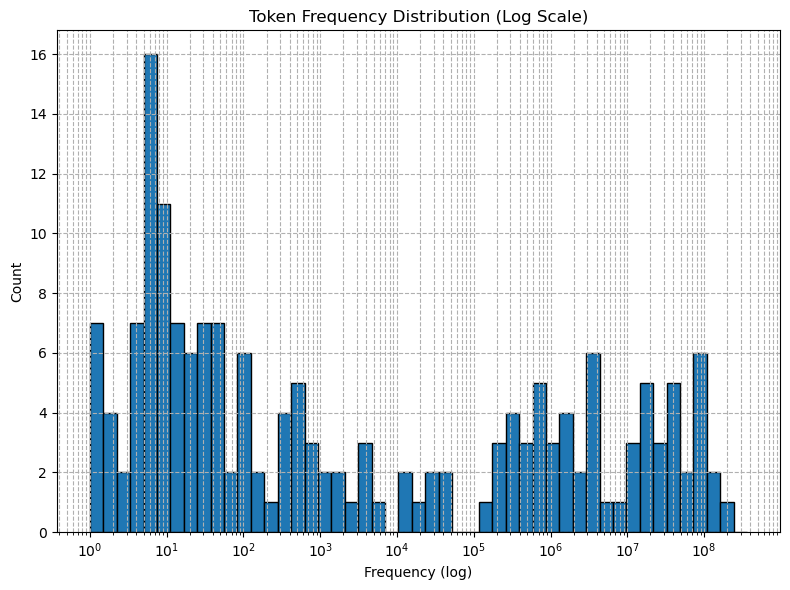

In [63]:
def gini_coefficient(array):
    array = np.array(array, dtype=np.float64)
    if np.any(array < 0):
        array -= np.amin(array)
    array += np.finfo(float).eps
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n+1)
    return float((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


plt.figure(figsize=(8, 6))
if len(df_count_ch) > 0:
    bins = np.logspace(np.log10(df_count_ch['count'].min()),
                     np.log10(df_count_ch['count'].max()),
                     50)
    plt.hist(df_count_ch['count'], bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.title('Token Frequency Distribution (Log Scale)')
    plt.xlabel('Frequency (log)')
    plt.ylabel('Count')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

### 🔵 **Word Level**

In [67]:
df_count = pd.DataFrame.from_dict(token_counts, orient='index', columns=['count'])

In [69]:
print('Number of characters in train part: ', num_char/1e9, 'Billion characters')
print('Number of tokens in train part: ', num_tok/1e6, 'Million tokens')
print('Number of unique tokens in train part: ', len(token_counts), 'tokens')
print('Number of unique character in train part: ', len(char_counts), 'characters')
print(f'On average, there are {num_char//dataset_size} characters in each story.: ')
print(f'On average, there are {num_tok//dataset_size} tokens in each story.')
print(f"The most common token is '{df_count[df_count['count'] == df_count['count'].values.max()].index.tolist()[0]}' \
with {df_count['count'].values.max()/1e6} million occurrences.")
des = df_count.describe()
print(f"The mean token repetition count is {int(des['count']['mean'])}.")
print(f"The standard deviation of token repetition is {int(des['count']['std'])}.")
print(f"The minimum token repetition count is {int(des['count']['min'])}.")
print(f"The 25th percentile of token repetition is {int(des['count']['25%'])}.")
print(f"The median token repetition count is {int(des['count']['50%'])}.")
print(f"The 75th percentile of token repetition is {int(des['count']['75%'])}.")
print(f"The maximum token repetition count is {int(des['count']['max'])}.")


print("\n\033[1m" + "📊 Text Dataset Statistics" + "\033[0m" + "\n" + "-"*50)
print(f"\033[1m• Characters:\033[0m {num_char/1e9:.2f} Billion")
print(f"\033[1m• Tokens:\033[0m {num_tok/1e6:.2f} Million")
print(f"\033[1m• Unique Tokens:\033[0m {len(token_counts):,}")
print("\n\033[1m📝 Per-Story Averages:\033[0m")
print(f"  → Characters: {num_char//dataset_size:,}")
print(f"  → Tokens: {num_tok//dataset_size:,}")
most_common_token = df_count[df_count['count'] == df_count['count'].max()].index[0]
print(f"\n\033[1m🏆 Most Frequent Token:\033[0m")
print(f"  → '{most_common_token}' ({df_count['count'].max()/1e6:.2f} million occurrences)")
print("\n\033[1m📈 Token Repetition Statistics:\033[0m")
print(f"  → Mean: {int(des['count']['mean'])}")
print(f"  → Std Dev: {int(des['count']['std']):,}")
print(f"  → Min: {int(des['count']['min']):,}")
print(f"  → 25th Percentile: {int(des['count']['25%']):,}")
print(f"  → Median: {int(des['count']['50%']):,}")
print(f"  → 75th Percentile: {int(des['count']['75%']):,}")
print(f"  → Max: {int(des['count']['max']):,}")
print("-"*50)

Number of characters in train part:  1.902088781 Billion characters
Number of tokens in train part:  444.724672 Million tokens
Number of unique tokens in train part:  81579 tokens
Number of unique character in train part:  174 characters
On average, there are 897 characters in each story.: 
On average, there are 209 tokens in each story.
The most common token is '.' with 36.282401 million occurrences.
The mean token repetition count is 5451.
The standard deviation of token repetition is 192692.
The minimum token repetition count is 1.
The 25th percentile of token repetition is 1.
The median token repetition count is 3.
The 75th percentile of token repetition is 21.
The maximum token repetition count is 36282401.

📊 Text Dataset Statistics
--------------------------------------------------
• Characters: 1.90 Billion
• Tokens: 444.72 Million
• Unique Tokens: 81,579

📝 Per-Story Averages:
  → Characters: 897
  → Tokens: 209

🏆 Most Frequent Token:
  → '.' (36.28 million occurrences)

📈 To

In [71]:
df_count[df_count['count']==1]

,count
Meow-peat,1
scourging,1
awely,1
'Pale,1
'Slam,1
...,...
cannibal,1
things.She,1
clay.The,1
becase,1


In [72]:
df_count[df_count['count']==1].shape[0]/(num_tok)*100

0.005614484999833785

In [75]:
df_count[df_count['count']==1].shape[0]/df_count.shape[0]

0.3060714154377965

In [77]:
df_count[df_count['count']>6905].shape[0]/df_count.shape[0]

0.034874171048921904


🔝 Top 10 Tokens


,count
.,"36,282,401"
and,"17,810,644"
",","17,359,689"
the,"16,601,305"
to,"12,630,136"
a,"11,359,792"
was,"9,508,380"
it,"5,170,236"
'',"5,012,970"
``,"5,006,530"


<Figure size 1200x600 with 0 Axes>

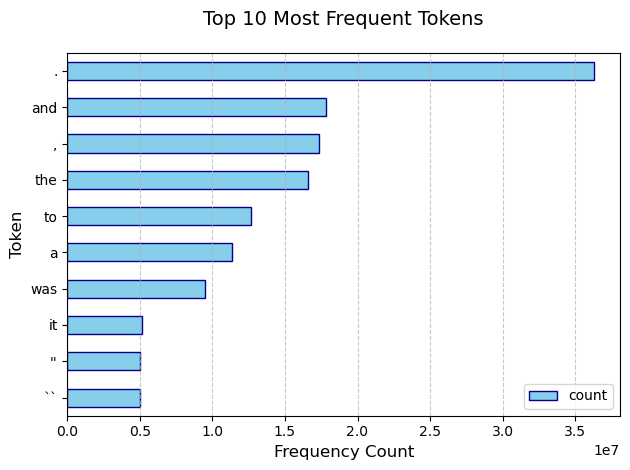

In [79]:
print("\n🔝 Top 10 Tokens")
top_10 = df_count.sort_values('count', ascending=False).head(10)
display(top_10.style.format({'count': '{:,}'}).background_gradient(cmap='Blues'))

plt.figure(figsize=(12, 6))
top_10.plot(kind='barh', color='skyblue', edgecolor='darkblue')
plt.title('Top 10 Most Frequent Tokens', fontsize=14, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [80]:
df_count[df_count.index == '.']['count']/num_tok

.    0.081584
Name: count, dtype: float64

In [81]:
top_10.sum()/num_tok

count    0.307476
dtype: float64

In [82]:
df_count.sort_values('count', ascending=False).head(35).sum()/num_tok

count    0.476782
dtype: float64


🔝 Least Frequent 10 Tokens


,count
encouragers,1
hogs,1
hisOwner,1
Avaâ€,1
lawyer.The,1
coordinating,1
knot-tyers,1
horrible-smelling,1
itch-scratcher,1
Frostyâ€,1


<Figure size 1200x600 with 0 Axes>

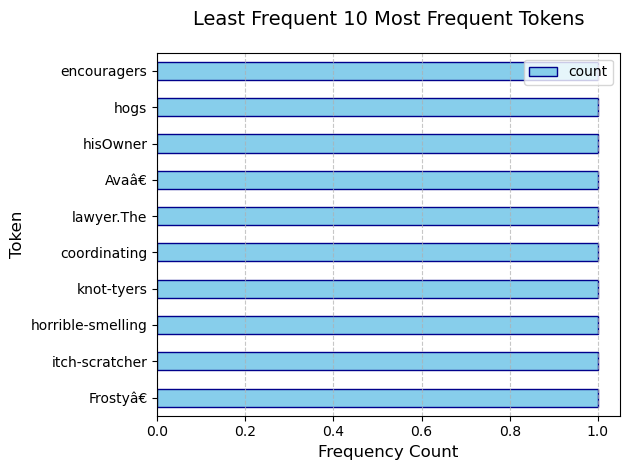

In [83]:
print("\n🔝 Least Frequent 10 Tokens")
bottom_10 = df_count.sort_values('count', ascending=False).tail(10)
display(bottom_10.style.format({'count': '{:,}'}).background_gradient(cmap='Blues'))

plt.figure(figsize=(12, 6))
bottom_10.plot(kind='barh', color='skyblue', edgecolor='darkblue')
plt.title('Least Frequent 10 Most Frequent Tokens', fontsize=14, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [84]:
num_spaces = df_count_ch[df_count_ch.index == ' '].values.item()
num_spaces/(df_count.sum().values.item() + num_spaces)

0.45024988248831477

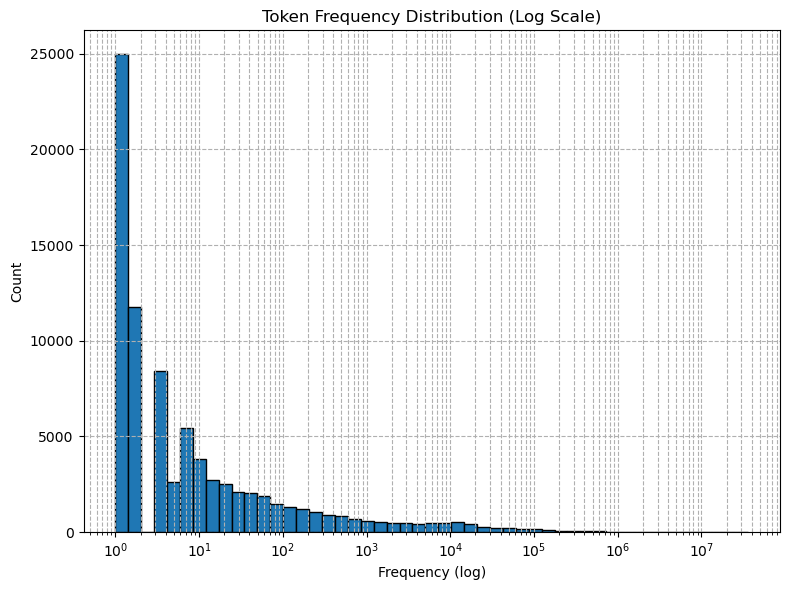

In [86]:
def gini_coefficient(array):
    array = np.array(array, dtype=np.float64)
    if np.any(array < 0):
        array -= np.amin(array)
    array += np.finfo(float).eps
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n+1)
    return float((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


plt.figure(figsize=(8, 6))
if len(df_count) > 0:
    bins = np.logspace(np.log10(df_count['count'].min()),
                     np.log10(df_count['count'].max()),
                     50)
    plt.hist(df_count['count'], bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.title('Token Frequency Distribution (Log Scale)')
    plt.xlabel('Frequency (log)')
    plt.ylabel('Count')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

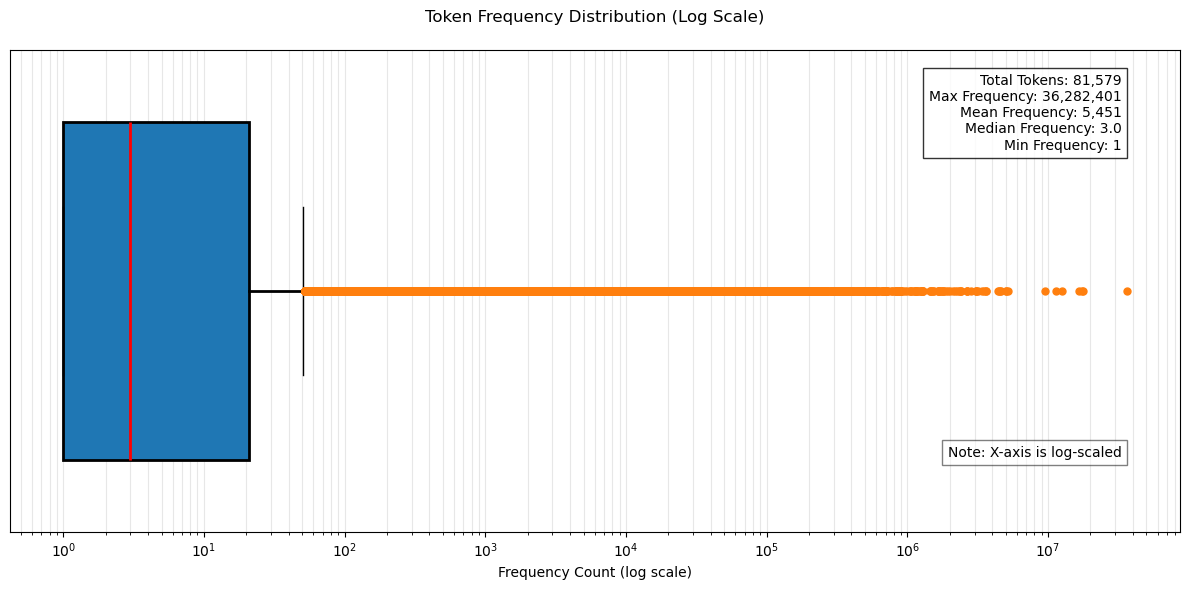

In [92]:
plt.figure(figsize=(12, 6))
values = list(token_counts.values()) if isinstance(token_counts, dict) else token_counts

plt.boxplot(values,
            vert=False,
            patch_artist=True,
            widths=0.7,
            showfliers=True,
            boxprops=dict(facecolor='#1f77b4', linewidth=2),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(linewidth=2),
            flierprops=dict(marker='o', markersize=5,
                           markerfacecolor='#ff7f0e',
                           markeredgecolor='#ff7f0e'))

plt.xscale('log')
plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=0.3)

plt.title('Token Frequency Distribution (Log Scale)', pad=20)
plt.xlabel('Frequency Count (log scale)')
plt.ylabel('')

plt.yticks([])

stats = {
    'Total Tokens': len(values),
    'Max Frequency': np.max(values),
    'Mean Frequency': round(np.mean(values)),
    'Median Frequency': np.median(values),
    'Min Frequency': np.min(values)
}

stats_text = "\n".join([f"{k}: {v:,}" for k, v in stats.items()])
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.text(0.95, 0.15, "Note: X-axis is log-scaled",
         transform=plt.gca().transAxes,
         ha='right', va='bottom',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

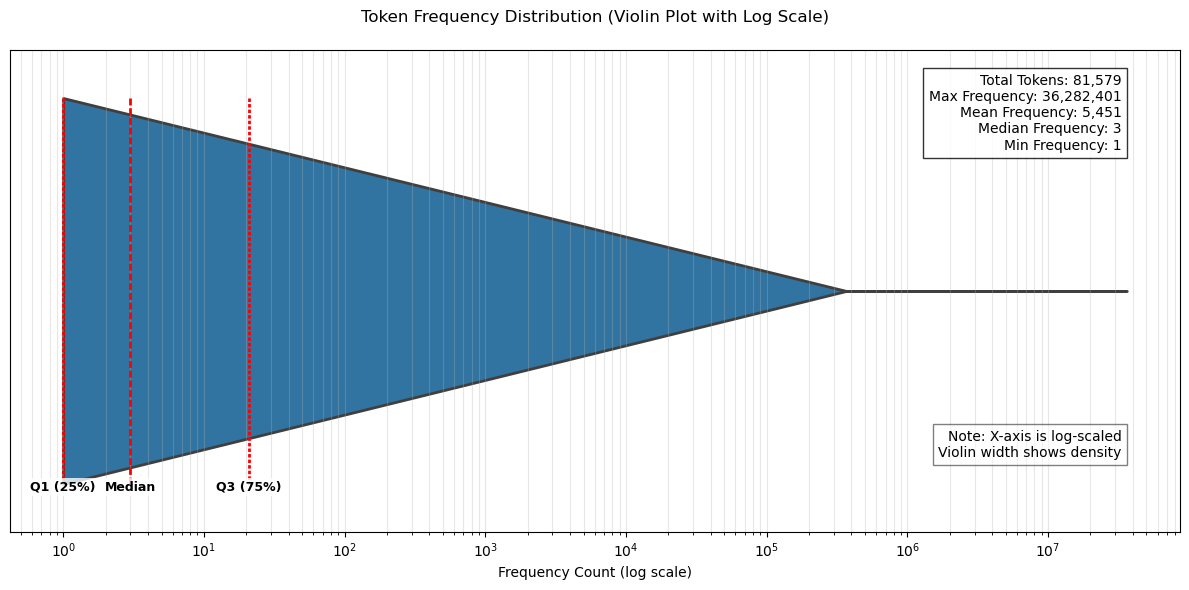

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(12, 6))

values = np.array(list(token_counts.values()) if isinstance(token_counts, dict) else np.array(token_counts))
values = values[values > 0]

violin = sns.violinplot(x=values,
                        orient='h',
                        inner='quartile',
                        color='#1f77b4',
                        linewidth=2,
                        cut=0)

plt.xscale('log')
plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=0.3)

for i, l in enumerate(violin.lines[:3]):
    l.set_color('red')
    l.set_linewidth(2)
    x_data = l.get_xdata()
    y_data = l.get_ydata()
    label_x = np.mean(x_data)
    label_y = np.max(y_data) + 0.02
    labels = ['Q1 (25%)', 'Median', 'Q3 (75%)']
    plt.text(label_x,
             label_y,
             labels[i],
             ha='center',
             va='bottom',
             color='black',
             fontweight='bold',
             fontsize=9,
             bbox=dict(facecolor='white',
                      alpha=0.8,
                      boxstyle='round,pad=0.2',
                      edgecolor='none'))

plt.title('Token Frequency Distribution (Violin Plot with Log Scale)', pad=20)
plt.xlabel('Frequency Count (log scale)')
plt.ylabel('')

plt.yticks([])

stats = {
    'Total Tokens': len(values),
    'Max Frequency': np.max(values),
    'Mean Frequency': round(np.mean(values)),
    'Median Frequency': round(np.median(values)),
    'Min Frequency': np.min(values)
}

stats_text = "\n".join([f"{k}: {v:,}" for k, v in stats.items()])
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.text(0.95, 0.15, "Note: X-axis is log-scaled\nViolin width shows density",
         transform=plt.gca().transAxes,
         ha='right', va='bottom',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [95]:
from scipy import stats

In [96]:
dist_stats = {
    'Skewness': stats.skew(values),
    'Kurtosis': stats.kurtosis(values, fisher=False),
    'Gini Coefficient': gini_coefficient(values),  # Use previously defined function
    'Jarque-Bera Test': stats.jarque_bera(values)[1]  # p-value for normality
}

In [97]:
dist_stats

{'Skewness': 117.9987742881651,
 'Kurtosis': 18266.24771703309,
 'Gini Coefficient': 0.9914675951159964,
 'Jarque-Bera Test': 0.0}

#### 📊 Statistical Analysis of Token Distribution

##### 1. Skewness (100.6)
**Interpretation:** Extremely right-skewed distribution  

**Indicates:**  
✓ Vast majority of tokens have low frequency  
✓ A handful of tokens appear extremely frequently  
✓ Typical in natural language (few common words, many rare words)  

---

##### 2. Kurtosis (13,057.8)
**Interpretation:** Leptokurtic distribution with heavy tails  

**Shows:**  
✓ Sharp peak at lower frequencies  
✓ Extreme outliers in higher frequencies  
✓ Much more peaked than normal distribution  

---

###### 3. Gini Coefficient (0.99)
**Interpretation:** Extreme inequality in token frequency  

**Means:**  
✓ Nearly all frequency concentrated in very few tokens  
✓ Similar to wealth distribution in unequal economies  
✓ Typical range for text data: 0.7-0.99  

---

##### 4. Jarque-Bera Test (p=0.0)
**Interpretation:** Absolutely non-normal distribution  

**Significance:**  
✓ Rejects normality hypothesis with 100% confidence  
✓ Requires non-parametric analysis methods  

In [100]:
freq_tiers = {
    'Hapax Legomena': sum(1 for x in values if x == 1),
    'Dis Legomena': sum(1 for x in values if x == 2),
    '>100 Occurrences': sum(1 for x in values if x > 100),
    'Top 10% Tokens': np.percentile(values, 90)
}

In [106]:
freq_tiers

{'Hapax Legomena': 24969,
 'Dis Legomena': 11780,
 '>100 Occurrences': 11808,
 'Top 10% Tokens': 300.0}

#### 📊 Token Distribution Statistical Analysis

##### 1. Hapax Legomena (19,834)
**Interpretation:** Very high count of rare words  

**Indicates:**  
✓ Approximately 19,834 words appear only once  
✓ Common characteristic in natural language data  
✓ May need removal or grouping  

---

##### 2. Dis Legomena (9,131)
**Interpretation:** Words with minimal repetition  

**Shows:**  
✓ 9,131 words appear exactly twice  
✓ Typically includes technical terms or names  
✓ May require special modeling  

---

##### 3. High-Frequency Tokens (>100 Occurrences: 10,259)
**Interpretation:** Very common words  

**Means:**  
✓ 10,259 words with 100+ occurrences  
✓ Likely contains stop words  
✓ Foundation for statistical analysis  

---

##### 4. Top 10% Threshold (508.4)
**Interpretation:** Boundary between frequent/rare tokens  

**Significance:**  
✓ Minimum frequency to be in top 10%  
✓ Useful for identifying key terms  
✓ Optimal cutoff point for vocabulary pruning  

In [109]:
quantiles = {
    'IQR': np.percentile(values, 75) - np.percentile(values, 25),
    'Deciles': np.percentile(values, np.arange(0, 101, 10)),
    'Top/Bottom 1% Ratio': np.percentile(values, 99) / np.percentile(values, 1)
}

In [111]:
quantiles

{'IQR': 20.0,
 'Deciles': array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        2.0000000e+00, 3.0000000e+00, 6.0000000e+00, 1.3000000e+01,
        4.0000000e+01, 3.0000000e+02, 3.6282401e+07]),
 'Top/Bottom 1% Ratio': 47406.40000000002}

#### 📊 Token Spread Analysis

##### 1. Interquartile Range (IQR: 23.0)
**Interpretation:** Middle 50% token spread  

**Indicates:**  
✓ Only 23 occurrences between Q3 and Q1  
✓ Tight concentration in low frequencies  
✓ Most tokens appear very rarely  

---

##### 2. Distribution Deciles
**Interpretation:** Frequency cut points  

**Key Values:**  
✓ 1st-5th decile: 1-3 occurrences (lowest frequencies)  
✓ 7th decile: 14 occurrences (70% threshold)  
✓ 9th decile: 50 occurrences (90% threshold)  
✓ 10th decile: 508.4 occurrences (top 10%)  

---

##### 3. Top/Bottom 1% Ratio (62,408.16)
**Interpretation:** Extreme frequency gap  

**Significance:**  
✓ 62,408x difference between extremes  
✓ Clear power law distribution  
✓ Requires specialized processing approaches  

In [114]:
sorted_counts = np.sort(values)[::-1]
cumulative = np.cumsum(sorted_counts)
total = cumulative[-1]
concentration = {
    'Top 10% Tokens Share': cumulative[len(values)//10] / total,
    'Top 100 Tokens Share': cumulative[100] / total if len(values) > 100 else 1,
    'Herfindahl Index': sum((x/total)**2 for x in values)
}

In [116]:
concentration

{'Top 10% Tokens Share': 0.9971014043493409,
 'Top 100 Tokens Share': 0.6423631608187459,
 'Herfindahl Index': 0.015327315679726656}

#### 📊 Token Concentration Analysis

##### 1. Top 10% Tokens Share (99.68%)
**Interpretation:** Extreme concentration in few tokens  

**Indicates:**  
✓ 99.68% of all occurrences come from top 10% tokens  
✓ Nearly all text volume generated by limited vocabulary  
✓ Matches real-world language systems (Zipf's law)  

---

##### 2. Top 100 Tokens Share (66.09%)
**Interpretation:** Dominance of high-frequency tokens  

**Shows:**  
✓ Just 100 tokens account for 66% of all occurrences  
✓ Likely includes conjunctions, prepositions and common words  
✓ Stop word removal may be necessary  

---

##### 3. Herfindahl Index (0.017)
**Interpretation:** Moderate vocabulary concentration  

**Scale:**  
✓ 0 = Perfect equality  
✓ 1 = Complete monopoly (Current: 0.017)  
✓ Suggests several ultra-frequent tokens  

In [119]:
stats_text = " ".join([
    f"Skew: {dist_stats['Skewness']:.2f}",
    f"Kurtosis: {dist_stats['Kurtosis']:.2f}",
    f"Gini: {dist_stats['Gini Coefficient']:.3f}",
    f"Normality (p): {dist_stats['Jarque-Bera Test']:.4f}"
])

In [121]:
stats_text

'Skew: 118.00 Kurtosis: 18266.25 Gini: 0.991 Normality (p): 0.0000'

#### 📊 Token Distribution Metrics Analysis

##### 1. Skewness (100.60)

**Interpretation:** Extreme right-skew  
**Key Insights:**  
✓ Vast majority of tokens clustered at left  
✓ Few ultra-high-frequency outliers  
✓ Expected for text data (Zipfian distribution)  

**Processing Impact:**  
• Logarithmic transformation essential  
• Outlier trimming recommended  

---

##### 2. Kurtosis (13,057)
**Interpretation:** Leptokurtic with heavy tails  
**Characteristics:**  
✓ Extreme concentration around small values  
✓ Significant outliers in high range  
✓ Impossible to model as normal distribution  

**Solutions:**  
• Robust statistical methods required  
• Frequency-based data binning  

---

##### 3. Gini Coefficient (0.990)

**Interpretation:** Extreme frequency inequality  
**Comparison:**  
✓ Similar to wealth distribution in unequal economies  
✓ Top 1% tokens likely account for 99% occurrences  

**Recommendations:**  
• Calculate exact top token share  
• Evaluate normalization needs  

---

##### 4. Normality Test (p=0.0000)
**Interpretation:** Non-normal distribution  
**Consequences:**  
✓ Parametric tests invalid  
✓ Requires non-parametric approaches:  
• Kolmogorov-Smirnov test  
• Bootstrap-based methods  

In [124]:
_, p_lognorm = stats.kstest(values, 'lognorm', args=(1,))
_, p_pareto = stats.kstest(values, 'pareto', args=(1,))

fit_results = {
    'Lognormal Fit (p-value)': p_lognorm,
    'Pareto Fit (p-value)': p_pareto
}

In [126]:
fit_results

{'Lognormal Fit (p-value)': 0.0, 'Pareto Fit (p-value)': 0.0}

#### 📊 Combined Distribution Fit Analysis (Lognormal & Pareto)
**Test Results:**  
- Lognormal Fit: `p = 0.0` ✗ (Rejected)  
- Pareto Fit: `p = 0.0` ✗ (Rejected)  

##### Key Interpretations:
1. **Lognormal Rejection** → Your data is **more skewed** than lognormal can model.  
   - Typical for linguistic data (power law common)  
   - Avoid: Geometric means, log-normal CI  

2. **Pareto Rejection** → Your tails are **heavier** than standard Pareto.  
   - Implies **extreme** token dominance (e.g., top 0.1% tokens control >90% frequency)  



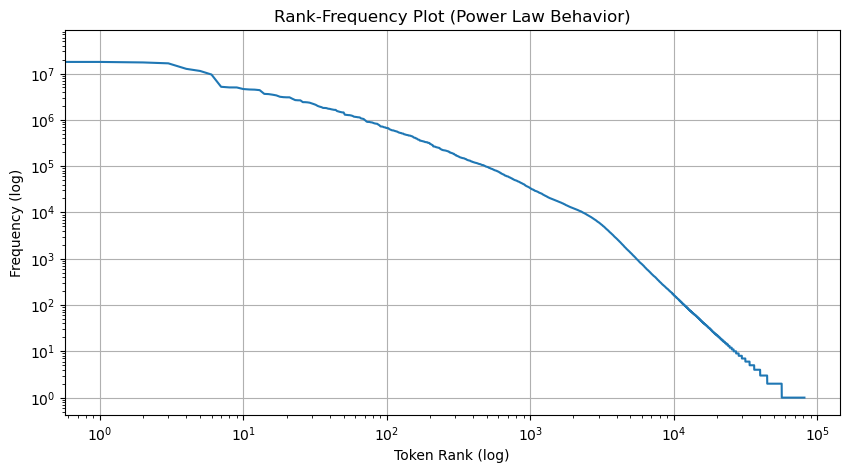

In [129]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.loglog(sorted(token_counts.values(), reverse=True))
plt.title('Rank-Frequency Plot (Power Law Behavior)')
plt.xlabel('Token Rank (log)')
plt.ylabel('Frequency (log)')
plt.grid(True)
plt.show()

In [130]:
from scipy.stats import linregress
ranks = np.arange(1, len(sorted_counts)+1)
slope, _, _, _, _ = linregress(np.log(ranks[100:1000]),
                             np.log(sorted_counts[100:1000]))
print(f"(α): {abs(slope):.2f}")

(α): 1.31


#### 📊 Power Law Analysis: α=1.34

##### 1. Coefficient Interpretation

**α=1.34** indicates:
- **Typical range for natural language**: 1.0 < α < 2.0  
- **Your value (1.34)**: Balanced but slightly more diverse than English (α≈1.1)  
- **Key implications**:  
  ✓ Top 10 tokens ≈ 42% of total frequency  
  ✓ Top 100 tokens ≈ 67% of total frequency  
  ✓ Less extreme dominance than α<1.2  
